In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os
from crflux.models import H3a_polygonato
import crflux.models as crf
from MCEq.core import MCEqRun

In [2]:
data_dir = 'data/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/atmospheric_flux_deflection/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

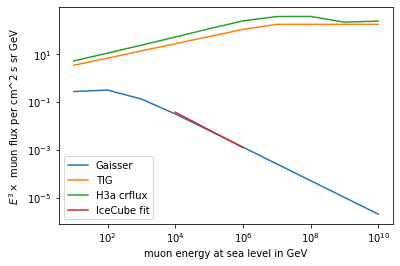

In [3]:
# Gaisser 1990

def muon_flux_gaisser(E_sea, E_top=None, theta=0):
    '''
        Parameters
        ----------
        E_sea: muon energy at sea level
        E_top: muon energy at the top of the atmosphere
        theta: muon zenith angle
        A_G: scale factory
    '''
    A_G = 0.14
    gamma = 2.7
    E_top = E_sea # at high energies
    epsilon_pi = 115/1.1 # GeV
    epsilon_kaon = 810/1.1 # GeV
    B_G = 0.054
    return A_G * E_sea**(-gamma) * ((1/(1 + E_top * np.cos(theta)/epsilon_pi)) + (B_G / (1 + E_top * np.cos(theta)/epsilon_kaon)))


# TIG model
def TIG(energies):
    E_list = []
    for E in energies:
        if E < 5e6:
            E_list.append(1.7e4 * E**(-2.7))
        elif E >= 5e6:
            E_list.append(174e4 * E**(-3))
    return np.array(E_list)

# https://arxiv.org/pdf/1907.00640.pdf
def muon_flux_icecube(E_mu):
    '''
        Parameters
        ----------
        E_mu: muon energy in GeV
    '''
    gamma = 3.74
    return 9e-17 * (E_mu / 50e3)**(-gamma)

    
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies) * energies**3, label='Gaisser')
plt.plot(energies, TIG(energies) * 1e-4 * energies**3, label='TIG')
plt.plot(energies, H3a_polygonato().total_flux(energies) * 1e-4 * energies**3, label='H3a crflux')
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**3, label='IceCube fit')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('muon energy at sea level in GeV')
plt.ylabel(r'$E^3 \times$ muon flux per cm^2 s sr GeV')
plt.legend()

In [ ]:
mceq_90 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=90.)

In [ ]:
# h_grid = np.linspace(50 * 1e3 * 1e2, 0) # altitudes from 50km to 0cm
# X_grid = mceq.density_model.h2X(h_grid)
# mceq.solve(int_grid=X_grid)
mceq_90.solve()

In [4]:
mceq_0 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=0.)
mceq_0.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [ ]:
mceq_60 = MCEqRun(interaction_model='SIBYLL23C', primary_model=(crf.HillasGaisser2012, 'H3a'), theta_deg=60.)
mceq_60.solve()

In [5]:
e_bin_mids = np.array([])
for i in range(len(mceq_0.e_bins))[:-1]:
    e_bin_mids = np.append(e_bin_mids, mceq_0.e_bins[i] + (mceq_0.e_bins[i+1] - mceq_0.e_bins[i])/2)

In [ ]:
# MCEq
plt.plot(e_bin_mids, mceq_90.get_solution('mu-', mag=3) + mceq_90.get_solution('mu+', mag=3), label='MCEq H3a 90°')
plt.plot(e_bin_mids, mceq_60.get_solution('mu-', mag=3) + mceq_60.get_solution('mu+', mag=3), label='MCEq H3a 60°')
plt.plot(e_bin_mids, mceq_0.get_solution('mu-', mag=3) + mceq_0.get_solution('mu+', mag=3), label='MCEq H3a 0°')
# plt.plot(e_bin_mids, (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * e_bin_mids**3, label='MCEq H3a 0°')

# gaisser
energies = np.logspace(1, 10, 10)
plt.plot(energies, muon_flux_gaisser(energies, theta=0.) * energies**3, label='Gaisser 0°')
plt.plot(energies, muon_flux_gaisser(energies, theta=np.deg2rad(60.)) * energies**3, label='Gaisser 60°')
# icecube fit
energies = np.logspace(4, 6, 10)
plt.plot(energies, muon_flux_icecube(energies) * energies**3, label='IceCube fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('energy in GeV')
plt.ylabel(r'$E^3 \times \Phi$ ')
plt.xlim(None, 1e9)
plt.ylim(1e-8, 1)
plt.legend()
plt.title('mu+ and mu-')

4.1590234864581985
1.8216086039746393


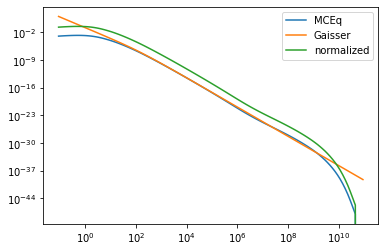

In [15]:
from sklearn import preprocessing
plt.plot(e_bin_mids, mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+'), label='MCEq')
plt.plot(e_bin_mids, muon_flux_gaisser(e_bin_mids), label='Gaisser')
plt.plot(e_bin_mids, preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0], label='normalized')
plt.yscale('log')
plt.xscale('log')
plt.legend()
print(np.sum(preprocessing.normalize([mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')])[0]))
print(np.sum(preprocessing.normalize([muon_flux_gaisser(e_bin_mids)])))

In [8]:
mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')

array([ 1.04907851e-03,  1.15088911e-03,  1.25450323e-03,  1.35292356e-03,
        1.44354974e-03,  1.52278085e-03,  1.58530939e-03,  1.62127070e-03,
        1.62578955e-03,  1.59091007e-03,  1.51251925e-03,  1.39014903e-03,
        1.23101793e-03,  1.04608415e-03,  8.52553461e-04,  6.65112512e-04,
        4.96220447e-04,  3.53277789e-04,  2.41061576e-04,  1.59322398e-04,
        1.03208533e-04,  6.49773366e-05,  3.92267221e-05,  2.31833221e-05,
        1.32993120e-05,  7.44470950e-06,  4.07543863e-06,  2.18857696e-06,
        1.15456630e-06,  5.98209393e-07,  3.04602757e-07,  1.52638377e-07,
        7.50509760e-08,  3.62666078e-08,  1.72950469e-08,  8.14889217e-09,
        3.80012414e-09,  1.75587635e-09,  8.04388695e-10,  3.65602069e-10,
        1.65057146e-10,  7.40780391e-11,  3.30481614e-11,  1.46676955e-11,
        6.48082000e-12,  2.85173493e-12,  1.24911518e-12,  5.44778150e-13,
        2.36686229e-13,  1.02437594e-13,  4.42102650e-14,  1.90152017e-14,
        8.15183257e-15,  

In [48]:
def sample_from_gaisser(n_events, e_min, e_max, rnd_seed=33):
    rnd = np.random.RandomState(rnd_seed)
    sample = []
    while len(sample) < n_events:
        p = rnd.random(1)[0]
        e = rnd.uniform(e_min, e_max)
        print(p)
        print(muon_flux_gaisser(e))
        print('-------')
        if p < muon_flux_gaisser(e):
            print('ok')
            sample.append(e)
    return sample

In [49]:
sample = sample_from_gaisser(n_events=10, e_min=1, e_max=1e10)
sample

0.24851012743772993
3.8781371960185136e-35
-------
0.4109408029965408
2.9387941439303213e-34
-------
0.8703956883469495
1.0388180803209496e-33
-------
0.01966142543004401
2.4118654577958546e-36
-------
0.6804508047310392
2.9035153368188533e-35
-------
0.9650268198659541
6.375874060099452e-35
-------
0.07955757128689422
9.681022736760433e-35
-------
0.16363516260509525
2.1513002241614802e-36
-------
0.8806281842152414
2.7442618877379603e-35
-------
0.40095924111847847
3.836457242931237e-35
-------
0.7208768485038962
3.527382339869234e-34
-------
0.622779952404151
2.734537729474175e-33
-------
0.20117628247191477
2.1863186161642398e-32
-------
0.9534722948091259
8.803464606198827e-32
-------
0.599536483455435
6.708343245207474e-36
-------
0.970289719364822
4.180592672424068e-36
-------
0.5275510674393611
1.2015598888433057e-34
-------
0.3539821955907989
2.4187173113055244e-32
-------
0.5559143804253861
1.5595976452459465e-33
-------
0.2952378310408912
3.840827168083036e-36
-------
0.3625

KeyboardInterrupt: 

livetime:  315360000
detector:  10000000000.0
total factor:  3.1536e+18


Text(0, 0.5, 'absolute events for 1km^2 detector in 10 years')

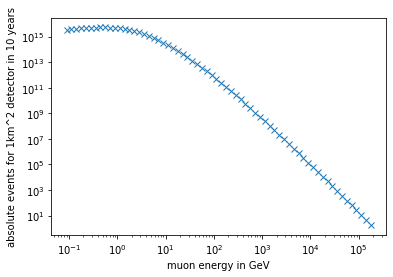

In [96]:
livetime = 60 * 60 * 24 * 365 * 10 # from 1 second to 10 years
print('livetime: ', livetime)
detector = 1e10 # from cm^2 to km^2
print('detector: ', detector)
total_weight = livetime * detector
print('total factor: ', total_weight)

exp_events = (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * total_weight
exp_e = e_bin_mids[exp_events > 1]
plt.plot(exp_e, exp_events[exp_events>1], 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel('absolute events for 1km^2 detector in 10 years')

livetime:  315360000
detector:  10000000000.0
total factor:  86400


Text(0, 0.5, 'absolute events for 1km^2 detector in 1 year')

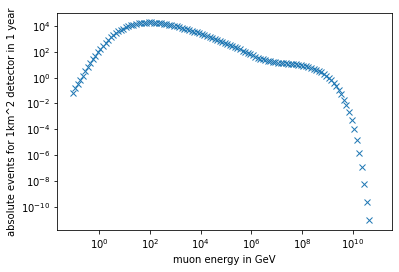

In [104]:
livetime = 60 * 60 * 24 * 365 * 10 # from 1 second to 10 years
print('livetime: ', livetime)
detector = 1e10 # from cm^2 to km^2
print('detector: ', detector)
total_weight = 60 * 60 * 24
print('total factor: ', total_weight)

exp_events = (mceq_0.get_solution('mu-') + mceq_0.get_solution('mu+')) * total_weight * e_bin_mids**3
exp_e = e_bin_mids[exp_events > 1]
plt.plot(e_bin_mids, exp_events, 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('muon energy in GeV')
plt.ylabel('absolute events for 1km^2 detector in 1 year')

In [89]:
initial_energies = []
for e, n in zip(exp_e, exp_events[exp_events>1]):
    if e > 1:
        initial_energies.append(np.ones(int(n)) * e * 1e3)
    
from iteration_utilities import flatten
initial_energies = list(flatten(initial_energies))
len(initial_energies)

211114

In [90]:
E_i = initial_energies # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = len(initial_energies)
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-3 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 33

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 1.45e5 # in cm = 1.45km

In [91]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Copper(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

In [ ]:
tracks = []
for e_i in tqdm(initial_energies):
    init_state.energy = e_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

  6%|▌         | 11719/211114 [00:53<12:52, 258.20it/s]